<a href="https://colab.research.google.com/github/netrasangani/Innovize_2025_Innovators-United-Soln/blob/main/Innovators_United_Innovize_2025_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

In [5]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/innovize_final_ml.csv')

Best Parameters: {'C': 2000, 'gamma': 0.002, 'kernel': 'rbf'}

Cross-Validation Accuracy Scores: [0.99635036 0.99817407 0.99695679 0.99878271 0.9957395 ]
Mean CV Accuracy: 99.72%


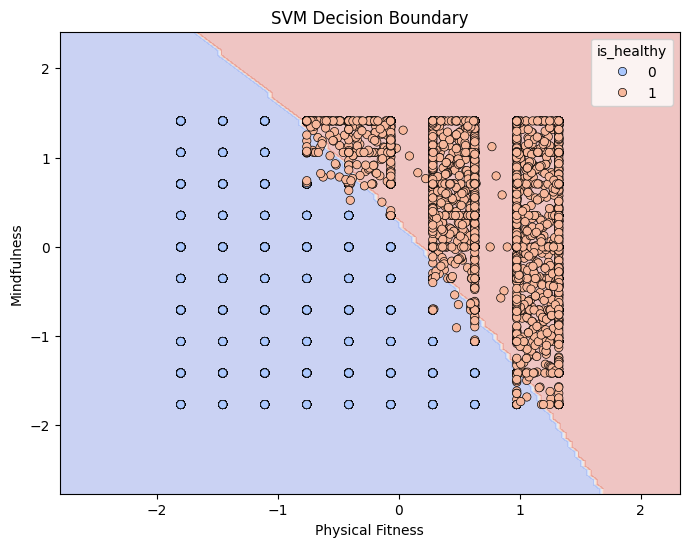

In [8]:
df.fillna(df.median(numeric_only=True), inplace=True)
df.fillna(df.mode().iloc[0], inplace=True)

df_encoded = pd.get_dummies(df, columns=['diet_pref', 'act_level', 'career'], drop_first=True)

X = df_encoded.drop(columns=['is_healthy'], errors='ignore')
y = df_encoded.get('is_healthy', pd.Series(dtype='int'))

num_cols = ['phy_fitness', 'sleep_hrs', 'mindfulness', 'gender', 'daily_avg_steps', 'daily_avg_calories']
num_cols = [col for col in num_cols if col in X.columns]
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

if y.nunique() > 1:
    smote = SMOTE(random_state=42)
    X, y = smote.fit_resample(X, y)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'C': [500, 1000, 2000],
    'gamma': [0.002, 0.005, 0.008],
    'kernel': ['rbf']
}

grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=kf, scoring='accuracy', n_jobs=-1)
grid_search.fit(X, y)

best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

svm_clf = SVC(kernel='rbf', C=best_params['C'], gamma=best_params['gamma'], random_state=42)

cv_scores = cross_val_score(svm_clf, X, y, cv=kf, scoring='accuracy', n_jobs=-1)
print(f"\nCross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores) * 100:.2f}%")

features = ['phy_fitness', 'mindfulness']
X_selected = X[features]


scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

svm_clf.fit(X_selected, y)

def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='coolwarm', edgecolor='k')
    plt.xlabel('Physical Fitness')
    plt.ylabel('Mindfulness')
    plt.title('SVM Decision Boundary')
    plt.show()

plot_decision_boundary(svm_clf, X_selected, y)